# Bayesian Inference in common conjugate families

In Bayesian inference, one models the data $X_1,\dots,X_n$ as arising from a distribution $p(x|\theta)$ with $\theta$ being the unknown parameter. This could be a parametric ($\theta$ is finite dimensional) or nonparametric model ($\theta$ is infinite dimensional, such as infinite mixtures or functions). Regardless, we place a *prior* on the parameter $\theta\sim \pi$, which captures the a-priori knowledge about the parameter. Then, the posterior distribution can be computed using Bayes rule

$$\pi(\theta|X_1,\dots,X_n) \propto \pi(\theta) p(X_1,\dots,X_n|\theta)$$

where the normalizing value is $\int \pi(\theta) p(x_1,\dots,x_n|\theta) d\theta$ is the marginal likelihood. In general, this posterior distribution captures both the a-priori information updated with the observed data and is the central object of inference in Bayesian setup. However, in general, this distribtion is not easy to compute or sample from.

A notable exception is for *conjugate* families, where the posterior $\pi(\theta|X)$ has the same parametric form as the prior $\pi(\theta)$. In this notebook, we go through some of these examples. In particular, our focus is to demonstrate the posterior contraction property.

In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as random
from bayesjax.conjugate.models import *

## Beta-Bernoulli model

Consider $X_1,\dots,X_n\sim \text{Bern}(\theta)$ with $\theta\in[0,1]$. Thus, the observatins are binary. The conjugate family is $\theta\sim \text{Beta}(\alpha_0,\beta_0)$. 

In [2]:
from jax.scipy.stats import beta

theta = 0.75
sample_size = 100
key = random.PRNGKey(0)
data = 1 * random.bernoulli(key, p=theta, shape=(sample_size,)) 

In [3]:
prior = BetaBinomial(alpha=2.0, beta=2.0)

In [4]:
# a-priori mean and variance
prior.mean_(), prior.variance_()

({'theta': 0.5}, {'theta': 0.05})

In [5]:
# model is actually beta-binomial - so adjust data
X = jnp.vstack([data, jnp.ones(sample_size)]).T
post = prior.posterior_params(X)

In [6]:
# posterior params
post.alpha, post.beta

(Array(72., dtype=float32), Array(32., dtype=float32))

In [7]:
# a-posteriori mean and variance
post.mean_(), post.variance_()

({'theta': Array(0.6923077, dtype=float32)},
 {'theta': Array(0.00202874, dtype=float32)})

In [8]:
# how to sample from posterior?
post.sample(key, num_samples=10)

Array([0.64724624, 0.73562276, 0.75049174, 0.72414243, 0.6823316 ,
       0.6872587 , 0.6078018 , 0.6727948 , 0.77237046, 0.7065776 ],      dtype=float32)

Let us see a visualization of the posterior contraction property in this model. For each value of sample size in $n\in \{10,20,40,80\}$, we draw random data from the ground-truth $R=3$ times and each time, compute the posterior distribution. 

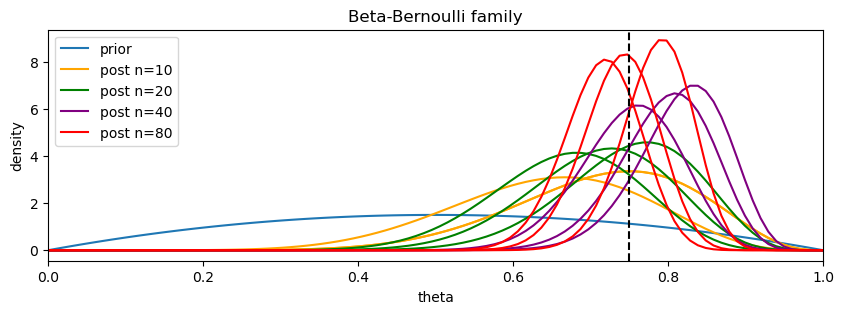

In [9]:
plt.subplots(figsize=(10,3))
keys = random.split(key, 4)
colors = ['orange', 'green', 'purple', 'red']
n = [10, 20, 40, 80]
z = jnp.linspace(0, 1, 100)

# prior density
f = beta.pdf(z, prior.alpha, prior.beta)
plt.plot(z, f, label='prior')
plt.xlim(0,1)
plt.xlabel('theta')

# posterior in each sample size
reps = 3
for i, sample_size in enumerate(n):
    keys_new = random.split(keys[i], reps)
    for j in range(reps):
        data = random.bernoulli(keys_new[j], p=theta, shape=(sample_size,)) 
        prior = BetaBinomial(alpha=2.0, beta=2.0)
        X = jnp.vstack([data, jnp.ones(sample_size)]).T
        post = prior.posterior_params(X)
        f = beta.pdf(z, post.alpha, post.beta)
        plt.plot(z, f, color=colors[i], label=f'post n={sample_size}')

plt.axvline(x=theta, color='black', linestyle='dashed')
handles, labels = plt.gca().get_legend_handles_labels()

# Create a dictionary to store unique labels and their first encountered handle
unique_legend_items = {}
for handle, label in zip(handles, labels):
    if label not in unique_legend_items:
        unique_legend_items[label] = handle

# Extract unique handles and labels in order
unique_handles = list(unique_legend_items.values())
unique_labels = list(unique_legend_items.keys())

# Create the legend with only distinct entries
plt.legend(unique_handles, unique_labels)
plt.title('Beta-Bernoulli family')
plt.ylabel('density')
plt.show()

This model can be generalized to Beta-Binomial model (the one actually implemented) and the Categorical-Dirichlet case (for more than 2 categories), also implemented.

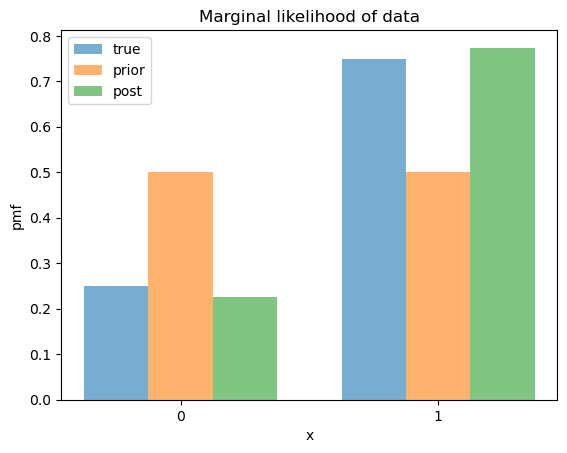

In [10]:
x_range = jnp.array([0,1])
key = random.PRNGKey(42)

prior = BetaBinomial(alpha=2.0, beta=2.0)
data = random.bernoulli(key, p=theta, shape=(sample_size,))
X = jnp.vstack([data, jnp.ones(sample_size)]).T

# true distribution of data
f_true = jnp.array([1-theta, theta])

# a-priori marginal likelihood
f_prior = prior.predictive_logpdf(jnp.array([[0, 1], [1, 1]]), data=jnp.zeros((1,2)))

# a-posterior marginal likelihood
f_post = prior.predictive_logpdf(jnp.array([[0, 1], [1, 1]]), data=X)

bins = jnp.array([0, 1])

# Width and offset for side-by-side bars
width = 0.25
offsets = [-width, 0, width]  # to shift bars side by side

plt.bar(bins + offsets[0], f_true, width=width, label='true', align='center', alpha=0.6)
plt.bar(bins + offsets[1], jnp.exp(f_prior), width=width, label='prior', align='center', alpha=0.6)
plt.bar(bins + offsets[2], jnp.exp(f_post), width=width, label='post', align='center', alpha=0.6)

plt.xticks(bins, ['0', '1'])

plt.title('Marginal likelihood of data')
plt.xlabel('x')
plt.ylabel('pmf')
plt.legend()
plt.show()

## Normal model with NIG prior

In this case $X_1,\dots,X_n\sim N(\mu,\sigma^2)$ with both the location and variance unknown. One of the choices for conjugate family is the normal-inverse gamma prior $(\mu,\sigma^2)\sim NIG(\mu_0, \kappa_0, \alpha_0, \beta_0)$, where $\beta_0$ is the rate, which is defined as

\begin{align}
    \sigma^2|\alpha_0,\beta_0 &\sim \text{Inv Gamma} (\alpha_0,\beta_0) \\
    \mu|\sigma^2, \mu_0, \kappa_0 &\sim N(\mu_0, \sigma^2/\kappa_0)
\end{align}

The marginal distributions are as follows

\begin{align}
    \sigma^2 &\sim \text{Inv Gamma} (\alpha_0,\beta_0) \\
    \sqrt{\frac{\alpha_0\kappa_0}{\beta_0}} (\mu - \mu_0) &\sim \text{t}_{2\alpha_0}
\end{align}

Let us see the contraction of the parameters in this case.

In [11]:
from jax.scipy.stats import norm, t, gamma
mu = 3.0
sigma = 1.5
sigma2 = sigma ** 2
print(f'ground truth mu={mu}, sigma2={sigma2}')
sample_size = 50
key = random.PRNGKey(0)
data = random.normal(key, shape=(sample_size,)) * sigma + mu

ground truth mu=3.0, sigma2=2.25


In [12]:
prior = NormalNormalInvGamma(mu0=0, kappa0=2.0, alpha0=3.0, beta0=3.0)
# a-priori mean and variance
prior.mean_(), prior.variance_()

({'mu': 0, 'sigma2': 1.5}, {'mu': 0.75, 'sigma2': 2.25})

In [13]:
# posterior params
post = prior.posterior_params(data)
print(f'mu    = {post.mu0}')
print(f'kappa = {post.kappa0}')
print(f'alpha = {post.alpha0}')
print(f'beta  = {post.beta0}')

mu    = 3.000917911529541
kappa = 52.0
alpha = 28.0
beta  = 68.76062774658203


In [14]:
# a-posteriori mean and variance
post.mean_(), post.variance_()

({'mu': Array(3.000918, dtype=float32),
  'sigma2': Array(2.54669, dtype=float32)},
 {'mu': Array(0.0489748, dtype=float32),
  'sigma2': Array(0.24944729, dtype=float32)})

In [15]:
mu_samples, sigma2_samples = post.sample(key, num_samples=5)
print(f'samples for mu: {mu_samples}')
print(f'samples for sigma2: {sigma2_samples}')

samples for mu: [2.462844  2.5108194 3.0435145 2.9259505 2.8647625]
samples for sigma2: [2.523677  3.0140524 2.2332764 2.3380065 1.6603235]


Let us check a similar visualization as before, using $n\in\{5, 10, 30, 60\}$. We show the distributions for $\mu$ and the precision parameter $\lambda=1/\sigma^2$, which follows Gamma distribution now.

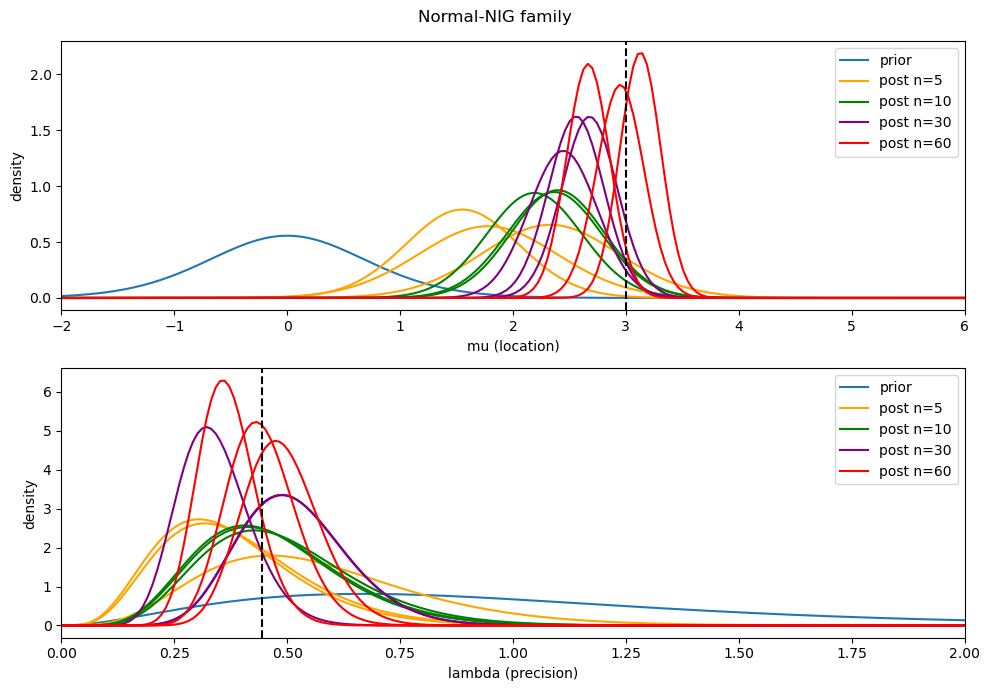

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,7))
prior = NormalNormalInvGamma(mu0=0, kappa0=2.0, alpha0=3.0, beta0=3.0)
keys = random.split(key, 4)
colors = ['orange', 'green', 'purple', 'red']
n = [5, 10, 30, 60]
z1 = jnp.linspace(-2, 6, 200)
z2 = jnp.linspace(0, 2, 200)

# prior density
f1 = t.pdf(z1, 
           df=2*prior.alpha0**2, 
           loc=prior.mu0, 
           scale=jnp.sqrt(prior.beta0/(prior.alpha0*prior.kappa0)))
ax1.plot(z1, f1, label='prior')
ax1.set_xlim(-2, 6)
ax1.set_xlabel('mu (location)')

f2 = gamma.pdf(z2,
               a=prior.alpha0,
               scale=1/prior.beta0)
ax2.plot(z2, f2, label='prior')
ax2.set_xlim(0, 2)
ax2.set_xlabel('lambda (precision)')

# posterior in each sample size
reps = 3
for i, sample_size in enumerate(n):
    keys_new = random.split(keys[i], reps)
    for j in range(reps):
        data = random.normal(keys_new[j], shape=(sample_size,)) * sigma + mu 
        prior = NormalNormalInvGamma(mu0=0, kappa0=2.0, alpha0=3.0, beta0=3.0)
        post = prior.posterior_params(data)

        f1 = t.pdf(z1, 
                   df=2*post.alpha0**2, 
                   loc=post.mu0, 
                   scale=jnp.sqrt(post.beta0/(post.alpha0*post.kappa0)))
        ax1.plot(z1, f1, color=colors[i], label=f'post n={sample_size}')
        
        f2 = gamma.pdf(z2,
                       a=post.alpha0,
                       scale=1/post.beta0)
        ax2.plot(z2, f2, color=colors[i], label=f'post n={sample_size}')

ax1.axvline(x=mu, color='black', linestyle='dashed')
ax2.axvline(x=1/sigma2, color='black', linestyle='dashed')

# Create the legend with only distinct entries
handles, labels = plt.gca().get_legend_handles_labels()

# Create a dictionary to store unique labels and their first encountered handle
unique_legend_items = {}
for handle, label in zip(handles, labels):
    if label not in unique_legend_items:
        unique_legend_items[label] = handle

# Extract unique handles and labels in order
unique_handles = list(unique_legend_items.values())
unique_labels = list(unique_legend_items.keys())
ax1.legend(unique_handles, unique_labels)
ax2.legend(unique_handles, unique_labels)
plt.suptitle('Normal-NIG family')
ax1.set_ylabel('density')
ax2.set_ylabel('density')
plt.tight_layout()
plt.show()

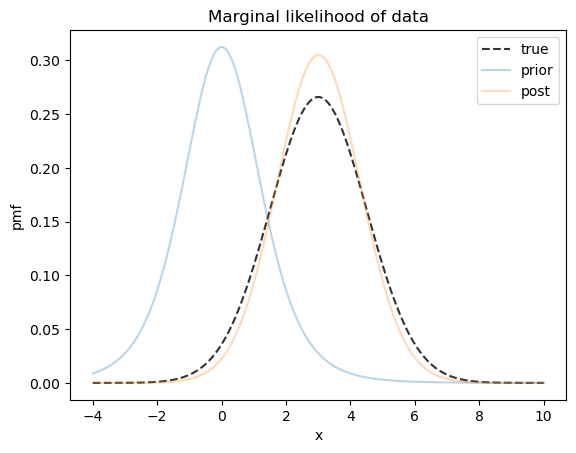

In [17]:
x_range = jnp.linspace(-4,10, 200)
key = random.PRNGKey(42)
mu0, kappa0, alpha0, beta0 = 0., 2., 3., 3.
prior = NormalNormalInvGamma(mu0=mu0, kappa0=kappa0, alpha0=alpha0, beta0=beta0)
data = random.normal(key, shape=(50,)) * sigma + mu

# true distribution of data
f_true = norm.pdf(x_range, loc=mu, scale=sigma)
plt.plot(x_range, f_true, alpha=0.8, label="true", color="black", linestyle="dashed")

# a-priori marginal likelihood
f_prior = t.logpdf(x_range, df=2*alpha0, loc=mu0, scale=jnp.sqrt(beta0 * (1 + 1 / kappa0) / alpha0))
plt.plot(x_range, jnp.exp(f_prior), alpha=0.3, label="prior")

# a-posterior marginal likelihood
f_post = prior.predictive_logpdf(x_range, data=data)
plt.plot(x_range, jnp.exp(f_post), alpha=0.3, label="post")

plt.title('Marginal likelihood of data')
plt.xlabel('x')
plt.ylabel('pmf')
plt.legend()
plt.show()

## Poisson-Gamma model

Here $X_1,\dots,X_n \sim \text{Poi}(\lambda)$ and the prior is $\lambda\sim \text{Gamma}(\alpha,\beta)$.

In [18]:
from jax.scipy.stats import gamma, poisson
lmbda = 3.0
print(f'ground truth lambda = {lmbda}')
sample_size = 100
key = random.PRNGKey(0)
data = random.poisson(key, lam=lmbda, shape=(sample_size,))

ground truth lambda = 3.0


In [19]:
prior = PoissonGamma(alpha=2.0, beta=0.3)
# a-priori mean and variance
prior.mean_(), prior.variance_()

({'lambda': 6.666666666666667}, {'lambda': 22.22222222222222})

In [20]:
# posterior moments
post = prior.posterior_params(data)
post.mean_(), post.variance_()

({'lambda': Array(2.7816548, dtype=float32, weak_type=True)},
 {'lambda': Array(0.02773335, dtype=float32, weak_type=True)})

In [21]:
post.sample(key, num_samples=5)

Array([2.768276 , 2.7901554, 2.7005858, 3.0005898, 2.9160886], dtype=float32)

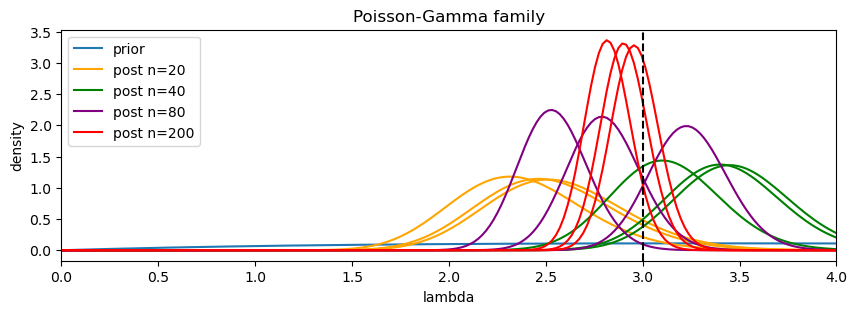

In [22]:
plt.subplots(figsize=(10,3))
keys = random.split(key, 4)
colors = ['orange', 'green', 'purple', 'red']
n = [20, 40, 80, 200]
z = jnp.linspace(0, 4, 200)

# prior density
f = gamma.pdf(z, a=prior.alpha, scale=1/prior.beta)
plt.plot(z, f, label='prior')
plt.xlim(0, 4)
plt.xlabel('lambda')

# posterior in each sample size
reps = 3
for i, sample_size in enumerate(n):
    keys_new = random.split(keys[i], reps)
    for j in range(reps):
        data = random.poisson(keys_new[j], lam=lmbda, shape=(sample_size,))
        prior = PoissonGamma(alpha=2.0, beta=0.3)
        post = prior.posterior_params(data)
        f = gamma.pdf(z, a=post.alpha, scale=1/post.beta)
        plt.plot(z, f, color=colors[i], label=f'post n={sample_size}')

plt.axvline(x=lmbda, color='black', linestyle='dashed')
handles, labels = plt.gca().get_legend_handles_labels()

# Create a dictionary to store unique labels and their first encountered handle
unique_legend_items = {}
for handle, label in zip(handles, labels):
    if label not in unique_legend_items:
        unique_legend_items[label] = handle

# Extract unique handles and labels in order
unique_handles = list(unique_legend_items.values())
unique_labels = list(unique_legend_items.keys())

# Create the legend with only distinct entries
plt.legend(unique_handles, unique_labels)
plt.title('Poisson-Gamma family')
plt.ylabel('density')
plt.show()

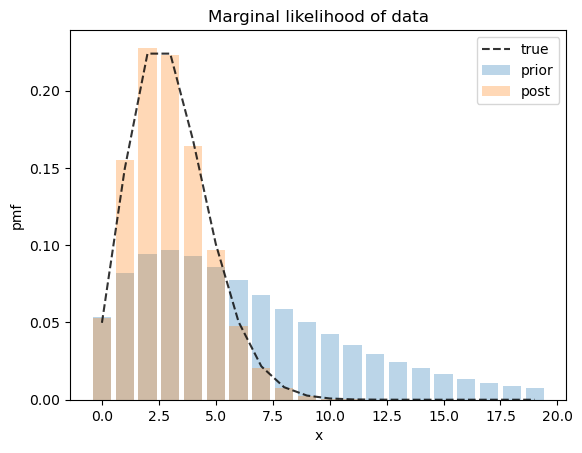

In [23]:
x_range = jnp.arange(20)
key = random.PRNGKey(42)
prior = PoissonGamma(alpha=2.0, beta=0.3)
data = random.poisson(key, lam=lmbda, shape=(sample_size,))

# true distribution
f_true = poisson.pmf(x_range, lmbda)
plt.plot(x_range, f_true, alpha=0.8, label="true", color="black", linestyle="dashed")

# a-priori marginal likelihood
f_prior = prior.predictive_logpdf(x_range, data=jnp.array([]))
plt.bar(x_range, jnp.exp(f_prior), alpha=0.3, label="prior")

# a-posterior marginal likelihood
f_post = prior.predictive_logpdf(x_range, data=data)
plt.bar(x_range, jnp.exp(f_post), alpha=0.3, label="post")

plt.title('Marginal likelihood of data')
plt.xlabel('x')
plt.ylabel('pmf')
plt.legend()
plt.show()

## Categorical - Dirichlet model (or multinomial)

Here $X_1,\dots,X_n\sim \text{Cat}(\theta)$ with $\theta\in\Delta^{K-1}$ where $K$ is the number of categories. The prior is $\theta\sim \text{Dir}(\alpha)$ with $\alpha\in R_+^K$. We just show one usage.

In [26]:
theta = jnp.array([0.25, 0.35, 0.4])
print(f'ground truth alpha = {theta}')
sample_size = 500
key = random.PRNGKey(0)
data = random.categorical(key, logits=jnp.log(theta), shape=(sample_size,))

ground truth alpha = [0.25 0.35 0.4 ]


In [27]:
counts = jnp.bincount(data, length=3)
counts

Array([112, 191, 197], dtype=int32)

In [28]:
prior = CategoricalDirichlet(alpha=jnp.ones(3))
# a-priori mean and variance
prior.mean_(), prior.variance_()

({'theta': Array([0.33333334, 0.33333334, 0.33333334], dtype=float32)},
 {'theta': Array([0.05555555, 0.05555555, 0.05555555], dtype=float32)})

In [29]:
# posterior moments from data
post = prior.posterior_params(data)
post.mean_(), post.variance_()

({'theta': Array([0.22465208, 0.38170975, 0.39363816], dtype=float32)},
 {'theta': Array([0.0003456 , 0.00046827, 0.00047359], dtype=float32)})

In [30]:
# posterior moments from statistics
post = prior.posterior_from_stats(counts)
post.mean_(), post.variance_()

({'theta': Array([0.22465208, 0.38170975, 0.39363816], dtype=float32)},
 {'theta': Array([0.0003456 , 0.00046827, 0.00047359], dtype=float32)})

In [31]:
post.sample(key, num_samples=4)

Array([[0.22595541, 0.38857505, 0.38546953],
       [0.23922047, 0.38252962, 0.37824988],
       [0.22827503, 0.35651618, 0.41520882],
       [0.2260352 , 0.37835798, 0.3956068 ]], dtype=float32)

## Gamma-Gamma model with known shape

In this case, $X_1,\dots,X_n\sim \text{Gamma}(\alpha, \beta)$ with known shape parameter $\alpha$. Note that this includes the case of exponential distribution when $\alpha=1$. The prior is $\beta\sim \text{Gamma}(\alpha_0, \beta_0). The posterior predictive in this case is a non-standard (but closed form) Lomax distribution.

In [32]:
alpha = 1.0 # exponential
beta = 0.3
print(f'ground truth alpha = {alpha}, beta = {beta}')
sample_size = 100
key = random.PRNGKey(0)
data = random.gamma(key, a=alpha, shape=(sample_size,)) / beta

ground truth alpha = 1.0, beta = 0.3


In [38]:
prior = GammaGamma(alpha0=2.0, beta0=2.0, alpha=1.0)
# a-priori mean and variance
prior.mean_(), prior.variance_()

({'beta': 1.0}, {'beta': 0.5})

In [34]:
# posterior moments
post = prior.posterior_params(data)
post.mean_(), post.variance_()

({'beta': Array(0.3213627, dtype=float32)},
 {'beta': Array(0.00101249, dtype=float32)})

In [35]:
post.sample(key, num_samples=4)

Array([0.3183947 , 0.32257146, 0.3055647 , 0.36345586], dtype=float32)

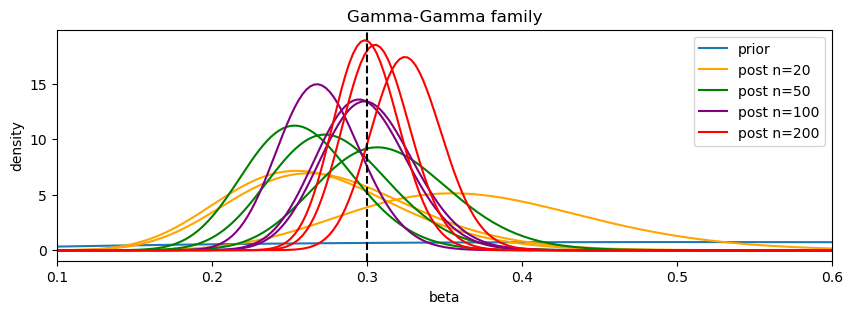

In [42]:
plt.subplots(figsize=(10,3))
keys = random.split(key, 4)
colors = ['orange', 'green', 'purple', 'red']
n = [20, 50, 100, 200]
z = jnp.linspace(0.1, 0.6, 200)

# prior density
f = gamma.pdf(z, a=prior.alpha0, scale=1/prior.beta0)
plt.plot(z, f, label='prior')
plt.xlim(0.1, 0.6)
plt.xlabel('beta')

# posterior in each sample size
reps = 3
for i, sample_size in enumerate(n):
    keys_new = random.split(keys[i], reps)
    for j in range(reps):
        data = random.gamma(keys_new[j], a=alpha, shape=(sample_size,)) / beta
        prior = GammaGamma(alpha0=2.0, beta0=2.0, alpha=1.0)
        post = prior.posterior_params(data)
        f = gamma.pdf(z, a=post.alpha0, scale=1/post.beta0)
        plt.plot(z, f, color=colors[i], label=f'post n={sample_size}')

plt.axvline(x=beta, color='black', linestyle='dashed')
handles, labels = plt.gca().get_legend_handles_labels()

# Create a dictionary to store unique labels and their first encountered handle
unique_legend_items = {}
for handle, label in zip(handles, labels):
    if label not in unique_legend_items:
        unique_legend_items[label] = handle

# Extract unique handles and labels in order
unique_handles = list(unique_legend_items.values())
unique_labels = list(unique_legend_items.keys())

# Create the legend with only distinct entries
plt.legend(unique_handles, unique_labels)
plt.title('Gamma-Gamma family')
plt.ylabel('density')
plt.show()

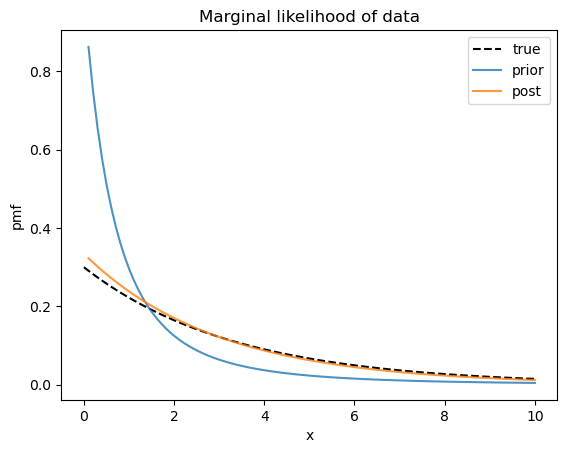

In [47]:
x_range = jnp.linspace(0, 10, 100)

key = random.PRNGKey(42)
prior = GammaGamma(alpha0=2.0, beta0=2.0, alpha=1.0)
data = random.gamma(keys_new[j], a=alpha, shape=(70,)) / beta

# true distribution
f_true = gamma.logpdf(x_range, a=alpha, scale=1/beta)
plt.plot(x_range, jnp.exp(f_true), alpha=1.0, label="true", color="black", linestyle="dashed")

# a-priori marginal likelihood
f_prior = prior.predictive_logpdf(x_range, data=jnp.array([]))
plt.plot(x_range, jnp.exp(f_prior), alpha=0.8, label="prior")

# a-posterior marginal likelihood
f_post = prior.predictive_logpdf(x_range, data=data)
plt.plot(x_range, jnp.exp(f_post), alpha=0.8, label="post")

plt.title('Marginal likelihood of data')
plt.xlabel('x')
plt.ylabel('pmf')
plt.legend()
plt.show()

## Multivariate Normal with Normal Inverse Wishart prior

The data is $X_1,\dots,X_n\sim N_d(\mu,\Sigma)$ with the prior $(\mu,\Sigma)$. The predictive distribution is a multivariate t-distribution. The prior parameters are $(\mu_0, \kappa_0, \Psi_0, \nu_0)$.

In [3]:
d = 2
mu = jnp.array([1., 2.])
Sigma = jnp.array([
    [1.0, -0.6],
    [-0.6, 2.0]
])
key = random.PRNGKey(0)
data = random.multivariate_normal(key, mean=mu, cov=Sigma, shape=(40,))

In [5]:
prior = NormalNormalInvWishart(
    mu0 = jnp.zeros(d),
    kappa0 = 2.0,
    psi0 = jnp.eye(d),
    nu0 = 5.0
)
# a-priori mean and variance
prior.mean_(), prior.variance_()

({'mu': Array([0., 0.], dtype=float32),
  'Sigma': Array([[0.5, 0. ],
         [0. , 0.5]], dtype=float32)},
 {'mu': Array([0.25, 0.25], dtype=float32)})

In [6]:
# posterior moments
post = prior.posterior_params(data)
post.mean_(), post.variance_()

({'mu': Array([0.9727395, 2.0795388], dtype=float32),
  'Sigma': Array([[ 0.8472188 , -0.41751653],
         [-0.41751653,  2.0224602 ]], dtype=float32)},
 {'mu': Array([0.02017188, 0.04815381], dtype=float32)})

In [7]:
post.sample(key, num_samples=5)

(Array([[0.87565553, 2.2419627 ],
        [1.0563432 , 2.1766872 ],
        [1.072356  , 1.8930112 ],
        [1.2600943 , 1.8299801 ],
        [1.2923832 , 1.5545677 ]], dtype=float32),
 Array([[[ 0.7154499 , -0.22414966],
         [-0.22414966,  1.8712342 ]],
 
        [[ 0.6355116 , -0.3472595 ],
         [-0.3472595 ,  1.5058209 ]],
 
        [[ 0.98155504,  0.14693846],
         [ 0.14693846,  2.6562314 ]],
 
        [[ 1.6304866 , -1.3210464 ],
         [-1.3210465 ,  2.6566896 ]],
 
        [[ 0.8203473 , -0.56385255],
         [-0.56385255,  1.7276549 ]]], dtype=float32))

In [8]:
prior.predictive_logpdf(data[:5], data)

Array([-5.157483 , -2.13874  , -2.5709035, -2.2806447, -2.8573096],      dtype=float32)